# Background

In [1]:
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
import datetime
import requests
import numpy as np
import pandas as pd
!pip install yfinance
import yfinance as yf

In [2]:
"""
def rolling_intercept(x, y, window_size):
    intercepts = []

    for i in range(len(x) - window_size + 1):
        x_window = x[i:i+window_size]
        y_window = y[i:i+window_size]

        # Calculate the intercept using numpy polyfit
        slope, intercept = np.polyfit(x_window, y_window, 1)
        intercepts.append(intercept)

    return intercepts
"""

'\ndef rolling_intercept(x, y, window_size):\n    intercepts = []\n\n    for i in range(len(x) - window_size + 1):\n        x_window = x[i:i+window_size]\n        y_window = y[i:i+window_size]\n\n        # Calculate the intercept using numpy polyfit\n        slope, intercept = np.polyfit(x_window, y_window, 1)\n        intercepts.append(intercept)\n\n    return intercepts\n'

In [3]:
"""
def rolling_slope(x, y, window_size):
    slopes = []

    for i in range(len(x) - window_size + 1):
        x_window = x[i:i+window_size]
        y_window = y[i:i+window_size]

        # Calculate the slope using numpy polyfit
        slope, intercept = np.polyfit(x_window, y_window, 1)
        slopes.append(slope)

    return slopes
"""

'\ndef rolling_slope(x, y, window_size):\n    slopes = []\n\n    for i in range(len(x) - window_size + 1):\n        x_window = x[i:i+window_size]\n        y_window = y[i:i+window_size]\n\n        # Calculate the slope using numpy polyfit\n        slope, intercept = np.polyfit(x_window, y_window, 1)\n        slopes.append(slope)\n\n    return slopes\n'

In [4]:
"""
#Creat a function to calucalte stock/market return caompare value with previuos one
def Return_Rate(x,y,z):
  x = x.rename(columns = {"Adj Close": y})
  x["Date"] = pd.to_datetime(x["Date"])
  x[y] = pd.to_numeric(x[y])
  x["REF"] = x[y].shift(periods=1)
  x[z] = (x[y]-x["REF"])/x["REF"]
  x = x.dropna()
  x = x[["Index", "Date",y,"REF", z]]
  return x
"""

'\n#Creat a function to calucalte stock/market return caompare value with previuos one\ndef Return_Rate(x,y,z):\n  x = x.rename(columns = {"Adj Close": y})\n  x["Date"] = pd.to_datetime(x["Date"])\n  x[y] = pd.to_numeric(x[y])\n  x["REF"] = x[y].shift(periods=1)\n  x[z] = (x[y]-x["REF"])/x["REF"]\n  x = x.dropna()\n  x = x[["Index", "Date",y,"REF", z]]\n  return x\n'

In [5]:
"""
import numpy as np
from scipy.stats import ttest_rel
import pandas as pd

def rolling_intercept(x, y, window_size):
    intercepts = []
    intercept_p_values = []

    for i in range(len(x) - window_size + 1):
        x_window = x[i:i+window_size]
        y_window = y[i:i+window_size]

        # Calculate the intercept using numpy polyfit
        slope, intercept = np.polyfit(x_window, y_window, 1)
        intercepts.append(intercept)

    # Perform t-test for the intercept
    t_stat, p_value = ttest_rel(intercepts, np.zeros_like(intercepts))
    intercept_p_values = [p_value] * len(intercepts)

    return intercepts, intercept_p_values

def rolling_slope(x, y, window_size):
    slopes = []
    slope_p_values = []

    for i in range(len(x) - window_size + 1):
        x_window = x[i:i+window_size]
        y_window = y[i:i+window_size]

        # Calculate the slope using numpy polyfit
        slope, intercept = np.polyfit(x_window, y_window, 1)
        slopes.append(slope)

    # Perform t-test for the slope
    t_stat, p_value = ttest_rel(slopes, np.zeros_like(slopes))
    slope_p_values = [p_value] * len(slopes)

    return slopes, slope_p_values
"""

'\nimport numpy as np\nfrom scipy.stats import ttest_rel\nimport pandas as pd\n\ndef rolling_intercept(x, y, window_size):\n    intercepts = []\n    intercept_p_values = []\n\n    for i in range(len(x) - window_size + 1):\n        x_window = x[i:i+window_size]\n        y_window = y[i:i+window_size]\n\n        # Calculate the intercept using numpy polyfit\n        slope, intercept = np.polyfit(x_window, y_window, 1)\n        intercepts.append(intercept)\n\n    # Perform t-test for the intercept\n    t_stat, p_value = ttest_rel(intercepts, np.zeros_like(intercepts))\n    intercept_p_values = [p_value] * len(intercepts)\n\n    return intercepts, intercept_p_values\n\ndef rolling_slope(x, y, window_size):\n    slopes = []\n    slope_p_values = []\n\n    for i in range(len(x) - window_size + 1):\n        x_window = x[i:i+window_size]\n        y_window = y[i:i+window_size]\n\n        # Calculate the slope using numpy polyfit\n        slope, intercept = np.polyfit(x_window, y_window, 1)\n    

# Type in Date and Trade Name

In [632]:
#History Data Time Frame
Startdate = "2014-1-1"
Enddate = "2024-04-10"

Beta_year = 5
B = Beta_year*12
B = int(B)
print(B)

Startdate = pd.to_datetime(Startdate) - relativedelta(years=Beta_year)
Enddate = pd.to_datetime(Enddate)

Trade_Name = "XOM"

Stock = yf.download(Trade_Name,start = Startdate, end = Enddate, interval='1mo')
Stock.insert(0, "Index", range(1, 1 + len(Stock)))
Stock = Stock.reset_index(drop=False)
print(Stock.Date[0].strftime("%Y-%m"))
print(Stock.Date.iloc[-1].strftime("%Y-%m"))

[*********************100%%**********************]  1 of 1 completed

60
2009-01
2024-04


In [633]:
assert Stock.Date[0] < Startdate + relativedelta(years=Beta_year)

In [634]:
from dateutil.relativedelta import relativedelta
# Calculate the difference in months
difference = relativedelta(Stock.Date.iloc[-1], Stock.Date.iloc[0])
total_months = difference.years * 12 + difference.months

assert total_months > B

# Basic Data

In [635]:
#Risk-Free rate taken as Treasury bond from Yahoo Finance: 13 Week Treasury Bill: ^IRX, 	Treasury Yield 5 Years: ^FVX, Treasury Yield 10 Years: ^TNX, Treasury Yield 30 Years: ^TYX
TB10 = yf.download("^TNX",start=Startdate,end=Enddate, interval='1mo')
TB10.insert(0, "Index", range(1, 1 + len(TB10)))


[*********************100%%**********************]  1 of 1 completed


In [636]:
TB30 = yf.download("^TYX",start=Startdate,end=Enddate, interval='1mo')
TB30.insert(0, "Index", range(1, 1 + len(TB10)))

[*********************100%%**********************]  1 of 1 completed


In [637]:
BIL = yf.download("BIL",start=Startdate,end=Enddate, interval='1mo')
BIL.insert(0, "Index", range(1, 1 + len(BIL)))

[*********************100%%**********************]  1 of 1 completed


In [638]:
SP_500 = yf.download("^GSPC",start=Startdate,end=Enddate, interval='1mo')
SP_500.insert(0, "Index", range(1, 1 + len(SP_500)))

[*********************100%%**********************]  1 of 1 completed


In [639]:
NASDAQ = yf.download("^IXIC",start=Startdate,end=Enddate, interval='1mo')
NASDAQ.insert(0, "Index", range(1, 1 + len(NASDAQ)))

[*********************100%%**********************]  1 of 1 completed


In [640]:
VTI = yf.download("VTI",start=Startdate,end=Enddate, interval='1mo')
VTI.insert(0, "Index", range(1, 1 + len(VTI)))

[*********************100%%**********************]  1 of 1 completed


In [641]:
Dow_Jones = yf.download("^DJI",start=Startdate,end=Enddate, interval='1mo')
Dow_Jones.insert(0, "Index", range(1, 1 + len(Dow_Jones)))

[*********************100%%**********************]  1 of 1 completed


In [642]:
#Market Return based on S&P500 Index data from Yahoo Finance
Market = SP_500
Market = Market.reset_index(drop=False)

Market.tail(10)

,Date,Index,Open,High,Low,Close,Adj Close,Volume
174,2023-07-01,175,4450.479980,4607.069824,4385.049805,4588.959961,4588.959961,75063200000
175,2023-08-01,176,4578.830078,4584.620117,4335.310059,4507.660156,4507.660156,86840820000
176,2023-09-01,177,4530.600098,4541.250000,4238.629883,4288.049805,4288.049805,73482980000
177,2023-10-01,178,4284.520020,4393.569824,4103.779785,4193.799805,4193.799805,83519460000
178,2023-11-01,179,4201.270020,4587.640137,4197.740234,4567.799805,4567.799805,80970570000
179,2023-12-01,180,4559.430176,4793.299805,4546.500000,4769.830078,4769.830078,81530670000
180,2024-01-01,181,4745.200195,4931.089844,4682.109863,4845.649902,4845.649902,81737880000
181,2024-02-01,182,4861.109863,5111.060059,4853.520020,5096.270020,5096.270020,82066930000
182,2024-03-01,183,5098.509766,5264.850098,5056.819824,5254.350098,5254.350098,86299510000
183,2024-04-01,184,5257.970215,5263.950195,4953.560059,5116.169922,5116.169922,77664700000


In [643]:
Market.describe()

,Date,Index,Open,High,Low,Close,Adj Close,Volume
count,184,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,1.840000e+02
mean,2016-08-15 22:41:44.347826176,92.500000,2472.739613,2558.688968,2389.945054,2493.339620,2493.339620,8.485072e+10
min,2009-01-01 00:00:00,1.000000,729.570007,832.979980,666.789978,735.090027,735.090027,5.813114e+10
25%,2012-10-24 06:00:00,46.750000,1415.304962,1465.219971,1397.722504,1423.687469,1423.687469,7.305674e+10
50%,2016-08-16 12:00:00,92.500000,2146.505005,2182.480103,2099.255005,2169.609985,2169.609985,8.091522e+10
75%,2020-06-08 12:00:00,138.250000,3237.912415,3351.707520,3128.239929,3240.575012,3240.575012,9.198947e+10
max,2024-04-01 00:00:00,184.000000,5257.970215,5264.850098,5056.819824,5254.350098,5254.350098,1.621854e+11
std,NaN,53.260367,1159.043192,1199.161992,1116.362953,1167.310392,1167.310392,1.755769e+10


In [644]:
Risk_Free = TB10
Risk_Free = Risk_Free.reset_index(drop=False)

Risk_Free.tail(100)

,Date,Index,Open,High,Low,Close,Adj Close,Volume
84,2016-01-01,85,2.230,2.261,1.911,1.931,1.931,0
85,2016-02-01,86,1.930,1.966,1.567,1.740,1.740,0
86,2016-03-01,87,1.749,2.002,1.728,1.786,1.786,0
87,2016-04-01,88,1.778,1.941,1.685,1.819,1.819,0
88,2016-05-01,89,1.816,1.890,1.705,1.834,1.834,0
...,...,...,...,...,...,...,...,...
179,2023-12-01,180,4.320,4.348,3.785,3.866,3.866,0
180,2024-01-01,181,3.969,4.198,3.894,3.967,3.967,0
181,2024-02-01,182,3.927,4.354,3.817,4.252,4.252,0
182,2024-03-01,183,4.268,4.348,4.038,4.206,4.206,0


In [645]:
Stock.head()

,Date,Index,Open,High,Low,Close,Adj Close,Volume
0,2009-01-01,1,80.059998,82.730003,74.010002,76.480003,43.496845,844182900
1,2009-02-01,2,76.059998,80.500000,67.900002,67.900002,38.617092,771508100
2,2009-03-01,3,67.000000,71.489998,61.860001,68.099998,38.925999,933460300
3,2009-04-01,4,67.040001,71.150002,64.500000,66.669998,38.108620,632859600
4,2009-05-01,5,67.129997,71.389999,65.599998,69.349998,39.640491,530458500


# Return Rate

In [646]:
#Calcuate risk free return for each month
Risk_Free = Risk_Free.rename(columns = {"Adj Close":"TB"})
Risk_Free["Date"] = pd.to_datetime(Risk_Free["Date"])
Risk_Free["TB"] = pd.to_numeric(Risk_Free["TB"])
#Risk_Free["Risk-Free Return"] = Risk_Free["TB"]/100
#Risk_Free["Risk-Free Return"] = ((1+Risk_Free["Risk-Free Return"])**(1/12))-1

#Risk_Free["Risk-Free Return"] = Risk_Free["TB"].apply(lambda x: ((1 + x / 100) ** (1/12)) - 1)
Risk_Free["Risk-Free Return"] = Risk_Free["TB"].apply(lambda x: (x/12)/100)


Risk_Free = Risk_Free.dropna()

"""
first_value = Risk_Free["Risk-Free Return"].iloc[0]
Risk_Free["Risk-Free Return"] = first_value
"""

Risk_Free = Risk_Free[["Index", "Date", "TB", "Risk-Free Return"]]

Risk_Free.tail(10)

,Index,Date,TB,Risk-Free Return
174,175,2023-07-01,3.959,0.003299
175,176,2023-08-01,4.093,0.003411
176,177,2023-09-01,4.573,0.003811
177,178,2023-10-01,4.875,0.004063
178,179,2023-11-01,4.352,0.003627
179,180,2023-12-01,3.866,0.003222
180,181,2024-01-01,3.967,0.003306
181,182,2024-02-01,4.252,0.003543
182,183,2024-03-01,4.206,0.003505
183,184,2024-04-01,4.614,0.003845


In [647]:
#Creat a function to calucalte stock/market return caompare value with previuos one

def Return_Rate(x, y, z):
    x = x.rename(columns={"Adj Close": y})
    x["Date"] = pd.to_datetime(x["Date"])
    x[y] = pd.to_numeric(x[y])
    x[y + "_Prev"] = x[y].shift(periods=1)
    x[z] = x[y].pct_change()
    x = x.dropna()

    return x


In [648]:
Stock = Return_Rate(Stock, "Stock Value", "Stock Return")

Market = Return_Rate(Market, "Market Value", "Market Return")

In [649]:
Stock.tail(10)

,Date,Index,Open,High,Low,Close,Stock Value,Volume,Stock Value_Prev,Stock Return
174,2023-07-01,175,107.489998,108.459999,100.220001,107.239998,104.433624,350338600,104.443375,-0.000093
175,2023-08-01,176,106.949997,112.070000,104.570000,111.190002,108.280273,315896100,104.433624,0.036833
176,2023-09-01,177,112.199997,120.699997,112.199997,117.580002,115.441681,320550000,108.280273,0.066138
177,2023-10-01,178,117.529999,117.790001,104.540001,105.849998,103.925003,493930700,115.441681,-0.099762
178,2023-11-01,179,106.529999,109.190002,101.150002,102.739998,100.871552,433367400,103.925003,-0.029381
179,2023-12-01,180,102.500000,104.220001,97.480003,99.980003,99.059380,453909500,100.871552,-0.017965
180,2024-01-01,181,100.919998,104.879997,95.769997,102.809998,101.863312,413171900,99.059380,0.028306
181,2024-02-01,182,103.570000,105.430000,100.419998,104.519997,103.557571,360899900,101.863312,0.016633
182,2024-03-01,183,105.720001,116.449997,104.029999,116.239998,116.239998,353938800,103.557571,0.122467
183,2024-04-01,184,116.410004,123.750000,115.379997,119.639999,119.639999,364055800,116.239998,0.029250


In [650]:
Market.tail(10)

,Date,Index,Open,High,Low,Close,Market Value,Volume,Market Value_Prev,Market Return
174,2023-07-01,175,4450.479980,4607.069824,4385.049805,4588.959961,4588.959961,75063200000,4450.379883,0.031139
175,2023-08-01,176,4578.830078,4584.620117,4335.310059,4507.660156,4507.660156,86840820000,4588.959961,-0.017716
176,2023-09-01,177,4530.600098,4541.250000,4238.629883,4288.049805,4288.049805,73482980000,4507.660156,-0.048719
177,2023-10-01,178,4284.520020,4393.569824,4103.779785,4193.799805,4193.799805,83519460000,4288.049805,-0.021980
178,2023-11-01,179,4201.270020,4587.640137,4197.740234,4567.799805,4567.799805,80970570000,4193.799805,0.089179
179,2023-12-01,180,4559.430176,4793.299805,4546.500000,4769.830078,4769.830078,81530670000,4567.799805,0.044229
180,2024-01-01,181,4745.200195,4931.089844,4682.109863,4845.649902,4845.649902,81737880000,4769.830078,0.015896
181,2024-02-01,182,4861.109863,5111.060059,4853.520020,5096.270020,5096.270020,82066930000,4845.649902,0.051721
182,2024-03-01,183,5098.509766,5264.850098,5056.819824,5254.350098,5254.350098,86299510000,5096.270020,0.031019
183,2024-04-01,184,5257.970215,5263.950195,4953.560059,5116.169922,5116.169922,77664700000,5254.350098,-0.026298


In [651]:
Market['Market Return'].tail(60).mean()*12

0.12761771935900593

# Premium

In [652]:
# Create a function to calculate the market/stock premium
# by taking the market/stock return and subtracting the risk free return
# Manipulating the data to fit our format by renaming columns
def Premium(x, y, z, a, b):
  x = pd.merge(y, Risk_Free, on = "Date")
  x[z] = x[a] - x["Risk-Free Return"]
  x = x[["Date", "Risk-Free Return", z, b]]
  x = x.rename(columns = {"Date_y":"Date"})
  return x

In [653]:
#Run function to get Market/Stock Premium
Market_Premium = Premium('Market_Premium', Market, 'Market Premium', 'Market Return', 'Market Return')

Stock_Premium = Premium('Stock_Premium', Stock, 'Stock Premium', 'Stock Return', 'Stock Return')

In [654]:
Market_Premium.tail(5)

,Date,Risk-Free Return,Market Premium,Market Return
178,2023-12-01,0.003222,0.041008,0.044229
179,2024-01-01,0.003306,0.012590,0.015896
180,2024-02-01,0.003543,0.048177,0.051721
181,2024-03-01,0.003505,0.027514,0.031019
182,2024-04-01,0.003845,-0.030143,-0.026298


In [655]:
Market_Premium.tail(12).mean()

Date                2023-10-16 08:00:00
Risk-Free Return               0.003487
Market Premium                 0.014486
Market Return                  0.017973
dtype: object

In [656]:
Stock_Premium.head(5)

,Date,Risk-Free Return,Stock Premium,Stock Return
0,2009-02-01,0.002534,-0.114721,-0.112186
1,2009-03-01,0.002237,0.005762,0.007999
2,2009-04-01,0.002603,-0.023602,-0.020998
3,2009-05-01,0.002887,0.037310,0.040198
4,2009-06-01,0.002936,0.011155,0.014091


# Beta and Cost of Equity Calculation

In [657]:
import numpy as np
from scipy.stats import ttest_1samp
import pandas as pd

def rolling_intercept_and_r_squared(x, y, window_size):
    intercepts = []
    intercept_p_values = []
    r_squared_values = []
    r_squared_adj_values = []

    for i in range(len(x) - window_size + 1):
        x_window = x[i:i+window_size]
        y_window = y[i:i+window_size]

        # Calculate the intercept using numpy polyfit
        slope, intercept = np.polyfit(x_window, y_window, 1)
        intercepts.append(intercept)

        # Calculate the R-squared value
        y_predicted = np.polyval([slope, intercept], x_window)
        residuals = y_window - y_predicted
        SSR = np.sum(residuals**2)
        SST = np.sum((y_window - np.mean(y_window))**2)
        r_squared = 1 - SSR / SST
        r_squared_values.append(r_squared)

        # Calculate the adjusted R-squared value
        n = len(y_window)
        k = 2  # Assuming two predictors (Market Premium and Stock Premium)
        r_squared_adj = 1 - ((1 - r_squared) * (n - 1) / (n - k - 1))
        r_squared_adj_values.append(r_squared_adj)

        # Perform t-test for the intercept
        t_stat, p_value = ttest_1samp(intercepts, 0)
        intercept_p_values.append(p_value)

    return intercepts, intercept_p_values, r_squared_values, r_squared_adj_values

def rolling_slope_and_r_squared(x, y, window_size):
    slopes = []
    slope_p_values = []
    r_squared_values = []
    r_squared_adj_values = []

    for i in range(len(x) - window_size + 1):
        x_window = x[i:i+window_size]
        y_window = y[i:i+window_size]

        # Calculate the slope using numpy polyfit
        slope, intercept = np.polyfit(x_window, y_window, 1)
        slopes.append(slope)

        # Calculate the R-squared value
        y_predicted = np.polyval([slope, intercept], x_window)
        residuals = y_window - y_predicted
        SSR = np.sum(residuals**2)
        SST = np.sum((y_window - np.mean(y_window))**2)
        r_squared = 1 - SSR / SST
        r_squared_values.append(r_squared)

        # Calculate the adjusted R-squared value
        n = len(y_window)
        k = 2  # Assuming two predictors (Market Premium and Stock Premium)
        r_squared_adj = 1 - ((1 - r_squared) * (n - 1) / (n - k - 1))
        r_squared_adj_values.append(r_squared_adj)

        # Perform t-test for the slope
        t_stat, p_value = ttest_1samp(slopes, 0)
        slope_p_values.append(p_value)

    return slopes, slope_p_values, r_squared_values, r_squared_adj_values

def Cost_of_Equity(x, y, z):
    x = pd.merge(y, z, on="Date")
    x = x.dropna()

    intercepts, intercept_p_values, r_squared_values, r_squared_adj_values = rolling_intercept_and_r_squared(
        x["Market Premium"], x["Stock Premium"], B
    )
    slopes, slope_p_values, _, _ = rolling_slope_and_r_squared(
        x["Market Premium"], x["Stock Premium"], B
    )

    x = x.iloc[B - 1:]

    x = x.dropna()



    x["Market Compound Rate_0"] = (1 + x["Market Return"])
    x["Market Investment"] = x["Market Compound Rate_0"].cumprod() * 1000

    x["Stock Compound Rate_0"] = (1 + x["Stock Return"])
    x["Stock Investment"] = x["Stock Compound Rate_0"].cumprod() * 1000

    x["Alpha"] = intercepts
    x["Beta"] = slopes
    x = x.rename(columns={"Risk-Free Return_x": "Risk-Free Return"})
    x = x.dropna()

    x["Cost of Equity"] = x["Risk-Free Return"] + x["Beta"] * (x["Market Premium"])
    x = x[["Date", "Risk-Free Return", "Market Investment", "Stock Investment", "Alpha", "Beta", "Cost of Equity"]]

    # Append p-values, R-squared, and adjusted R-squared values to the DataFrame
    x["Alpha_p_value"] = intercept_p_values
    x["Beta_p_value"] = slope_p_values
    x["R-squared"] = r_squared_values
    x["R-squared_adj"] = r_squared_adj_values

    # Round specific columns to 2 decimal places
    columns_to_round = ["Risk-Free Return", "Market Investment", "Stock Investment", "Alpha", "Beta", "Cost of Equity",
                        "Alpha_p_value", "Beta_p_value", "R-squared", "R-squared_adj"]
    x[columns_to_round] = x[columns_to_round].round(3)

    return x


# Cost of Equity result

In [658]:
COE = Cost_of_Equity("COE", Market_Premium, Stock_Premium)
COE.head()

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1103: RuntimeWarning:

divide by zero encountered in divide

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1103: RuntimeWarning:

invalid value encountered in scalar multiply



,Date,Risk-Free Return,Market Investment,Stock Investment,Alpha,Beta,Cost of Equity,Alpha_p_value,Beta_p_value,R-squared,R-squared_adj
59,2014-01-01,0.002,964.417,910.672,-0.004,0.742,-0.026,NaN,NaN,0.436,0.417
60,2014-02-01,0.002,1006.000,951.285,-0.003,0.713,0.031,0.093,0.013,0.385,0.364
61,2014-03-01,0.002,1012.974,972.054,-0.003,0.748,0.006,0.024,0.000,0.403,0.382
62,2014-04-01,0.002,1019.255,1019.124,-0.001,0.823,0.005,0.024,0.000,0.456,0.437
63,2014-05-01,0.002,1040.690,1000.415,-0.002,0.822,0.018,0.010,0.000,0.447,0.427


In [659]:
Beta = COE["Beta"].tail(1).round(2)
Market_Mean = Market["Market Return"].tail(60).mean() * 12
equity = COE["Cost of Equity"].tail(60).mean()
annual_equity = equity * 12
alpha = COE["Alpha"].tail(12).mean()
annualized_alpha = alpha * 12

# Corrected print statement for Beta
print(f"Beta is {Beta.iloc[0]}")
print(f"Annualized Market Return is {Market_Mean:.2%}")
print(f"Average Monthly Cost of Equity is {equity:.2%}")
print(f"Annualized Cost of Equity is {annual_equity:.2%}")
print(f"Average Monthly Alpha is {alpha:.2%}")
print(f"Annualized Alpha is {annualized_alpha:.2%}")


Beta is 0.94
Annualized Market Return is 12.76%
Average Monthly Cost of Equity is 1.34%
Annualized Cost of Equity is 16.02%
Average Monthly Alpha is 0.45%
Annualized Alpha is 5.40%


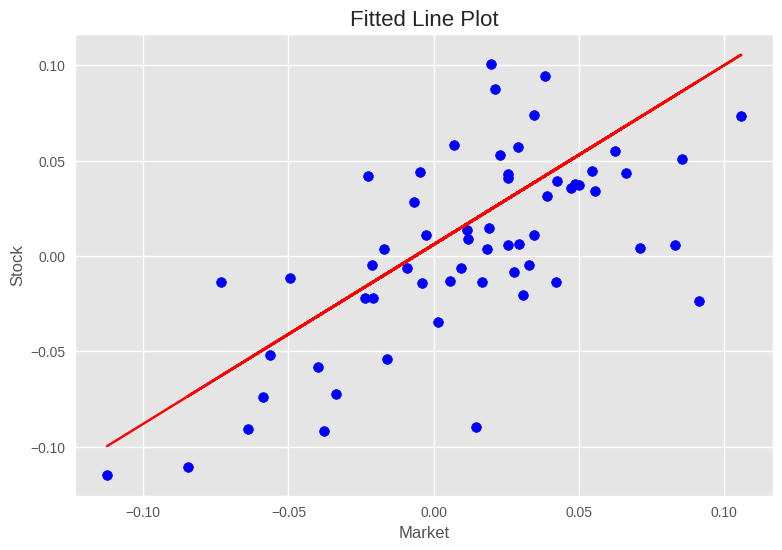

In [660]:
plt.style.use('ggplot')

fig, axes = plt.subplots()
fig.set_size_inches(9, 6)

axes.scatter(Market_Premium["Market Premium"][:60], Stock_Premium["Stock Premium"][:60], color = 'blue')

axes.plot(Market_Premium["Market Premium"][:60],Market_Premium["Market Premium"][:60] * Beta.values + COE['Alpha'].tail(1).values, color = 'red')
axes.set(title = "Fitted Line Plot", xlabel = "Market", ylabel = "Stock")
axes.title.set_size(16)

#axes.set_ylim([-0.25, 0.25])
#axes.set_ylim([Stock_Premium["Stock Premium"].rolling(60).min().min()/1.2, Stock_Premium["Stock Premium"].rolling(60).max().max()*1.2])


plt.show()

# Trend line

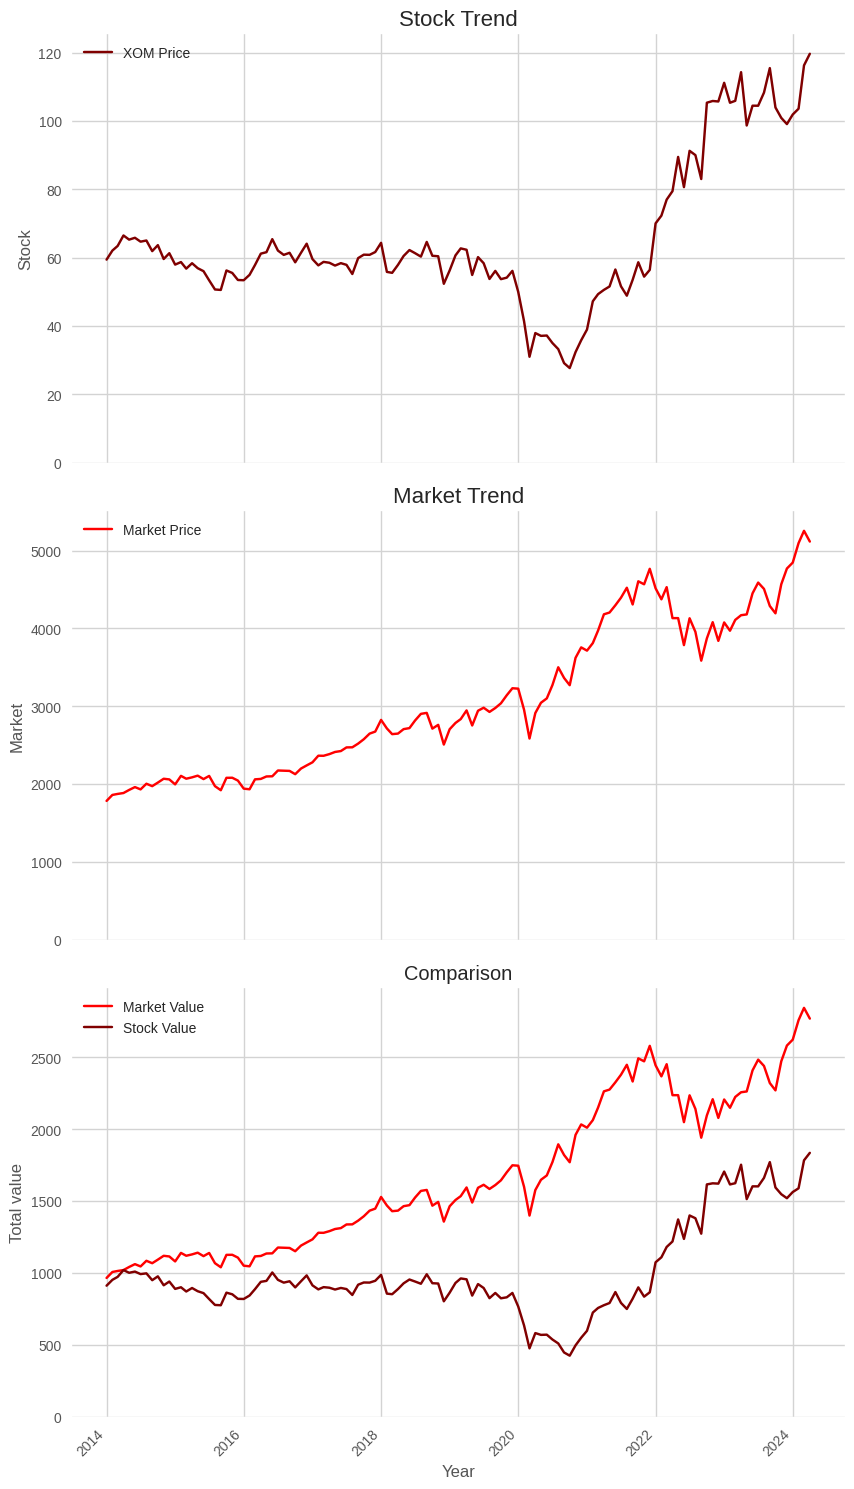

In [661]:
plt.style.use('ggplot')

# Chart of cost of equity for each year for Amazon stock graphically represented from 2002 to 2022
fig, axes = plt.subplots(nrows = 3, ncols = 1)
fig.set_size_inches(10, 15)
Max_Stock = Stock["Stock Value"].abs().max()*1.05
Max_Market = Market["Market Value"].abs().max()*1.05
max_abs_value = max(Max_Stock.max(), Max_Market.max()) * 1.05
max_abs_value_investment = max((COE["Market Investment"].max()), (COE["Stock Investment"].max())) * 1.05
axes[0].plot(Stock["Date"][B-1:], Stock["Stock Value"][B-1:], color = "maroon")
axes[0].set(title = "Stock Trend", xlabel = "Year", ylabel = "Stock")
axes[0].title.set_size(16)
plt.grid(color = "lightgray")
axes[1].plot(Market["Date"][B-1:], Market["Market Value"][B-1:], color = "red")
axes[1].set(title = "Market Trend", xlabel = "Year", ylabel = "Market")
axes[2].plot(COE["Date"], COE["Market Investment"],  color = "red")
axes[2].plot(COE["Date"], COE["Stock Investment"], color = "maroon")

axes[2].set(title = "Comparison", xlabel = "Year", ylabel = "Total value")

fig.autofmt_xdate(rotation=45) #format x-axis as date, rotate 45 degrees
axes[1].title.set_size(16)
axes[0].set_ylim([0,Max_Stock])
axes[1].set_ylim([0,Max_Market])
axes[2].set_ylim([0,max_abs_value_investment])

axes[0].set_facecolor('white') #make background behind grid white
axes[1].set_facecolor('white')
axes[2].set_facecolor('white')


axes[0].legend([Trade_Name +" Price"] ,loc = 2) #move legend to right
axes[1].legend(["Market Price"] ,loc = 2)
axes[2].legend([ "Market Value", "Stock Value",] ,loc = 2)
fig.tight_layout() #use tight layout
fig.subplots_adjust(right = .85) #adjust subplots to make legend fit, adjusted this a bit from smaller figure example!
axes[0].grid(color = "lightgray")
axes[1].grid(color = "lightgray")
axes[2].grid(color = "lightgray")

plt.show()

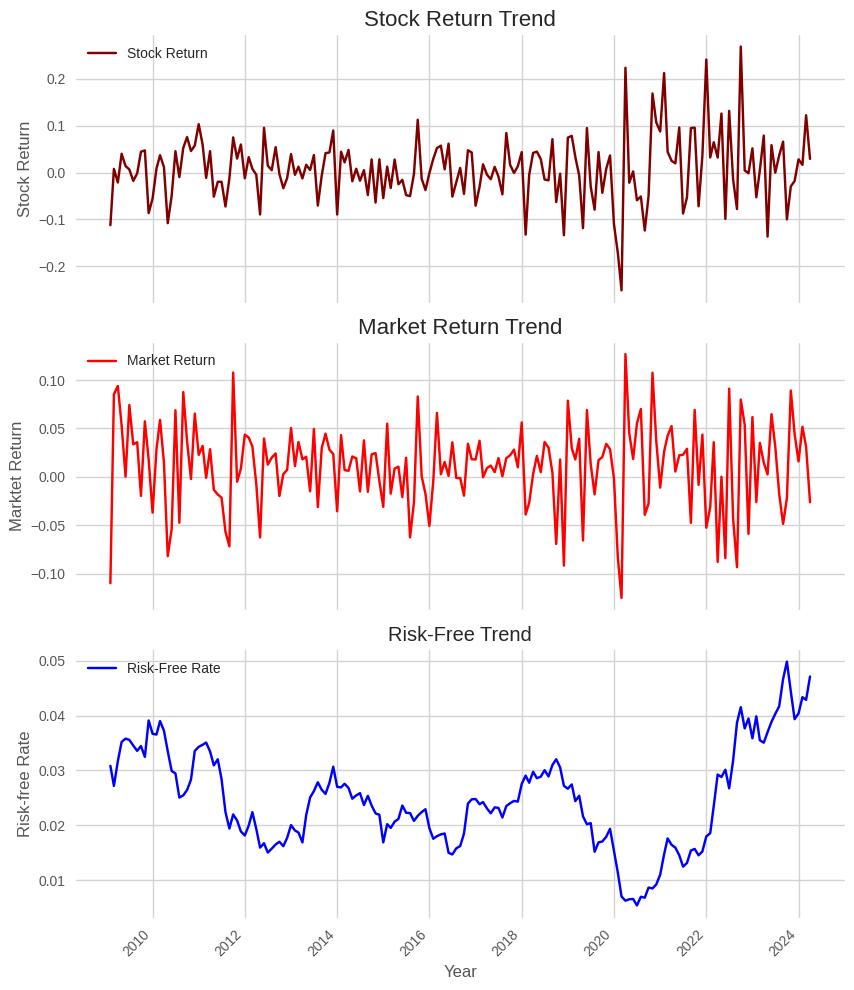

In [662]:
# Chart of cost of equity for each year for Amazon stock graphically represented from 2002 to 2022
fig, axes = plt.subplots(nrows = 3, ncols = 1)
fig.set_size_inches(10, 10)

#Moving_average_Stock = Stock["Stock Return"].rolling(12).mean()*12
#Moving_average_Market = Market["Market Return"].rolling(12).mean()*12

max_abs_value = max(Stock["Stock Return"].abs().max(), Market["Market Return"].abs().max()) * 1.05
axes[0].plot(Stock["Date"], Stock["Stock Return"], color = "maroon")
axes[0].set(title = "Stock Return Trend", xlabel = "Year", ylabel = "Stock Return")
axes[0].title.set_size(16)
#plt.grid(color = "lightgray")
axes[1].plot(Market["Date"], Market["Market Return"], color = "red")
axes[1].set(title = "Market Return Trend", xlabel = "Year", ylabel = "Marktet Return")
axes[2].plot(Risk_Free["Date"][1:], (1+Risk_Free["Risk-Free Return"][1:])**12-1, color = "blue")
axes[2].set(title = "Risk-Free Trend", xlabel = "Year", ylabel = "Risk-free Rate")
fig.autofmt_xdate(rotation=45) #format x-axis as date, rotate 45 degrees
axes[1].title.set_size(16)

#axes[0].set_ylim([-max_abs_value, max_abs_value])
#axes[1].set_ylim([-max_abs_value, max_abs_value])
#axes[2].set_ylim([0, Risk_Free["Risk-Free Return"].abs().max()*12*1.05])

axes[0].set_facecolor('white') #make background behind grid white
axes[1].set_facecolor('white')
axes[0].legend([ "Stock Return"] ,loc = 2) #move legend to right
axes[1].legend([ "Market Return"] ,loc = 2)
axes[2].legend([ "Risk-Free Rate"] ,loc = 2)
axes[0].set_facecolor('white') #make background behind grid white
axes[1].set_facecolor('white')
axes[2].set_facecolor('white')
fig.tight_layout() #use tight layout
fig.subplots_adjust(right = .85) #adjust subplots to make legend fit, adjusted this a bit from smaller figure example!
axes[0].grid(color = "lightgray")
axes[1].grid(color = "lightgray")
axes[2].grid(color = "lightgray")
plt.show()

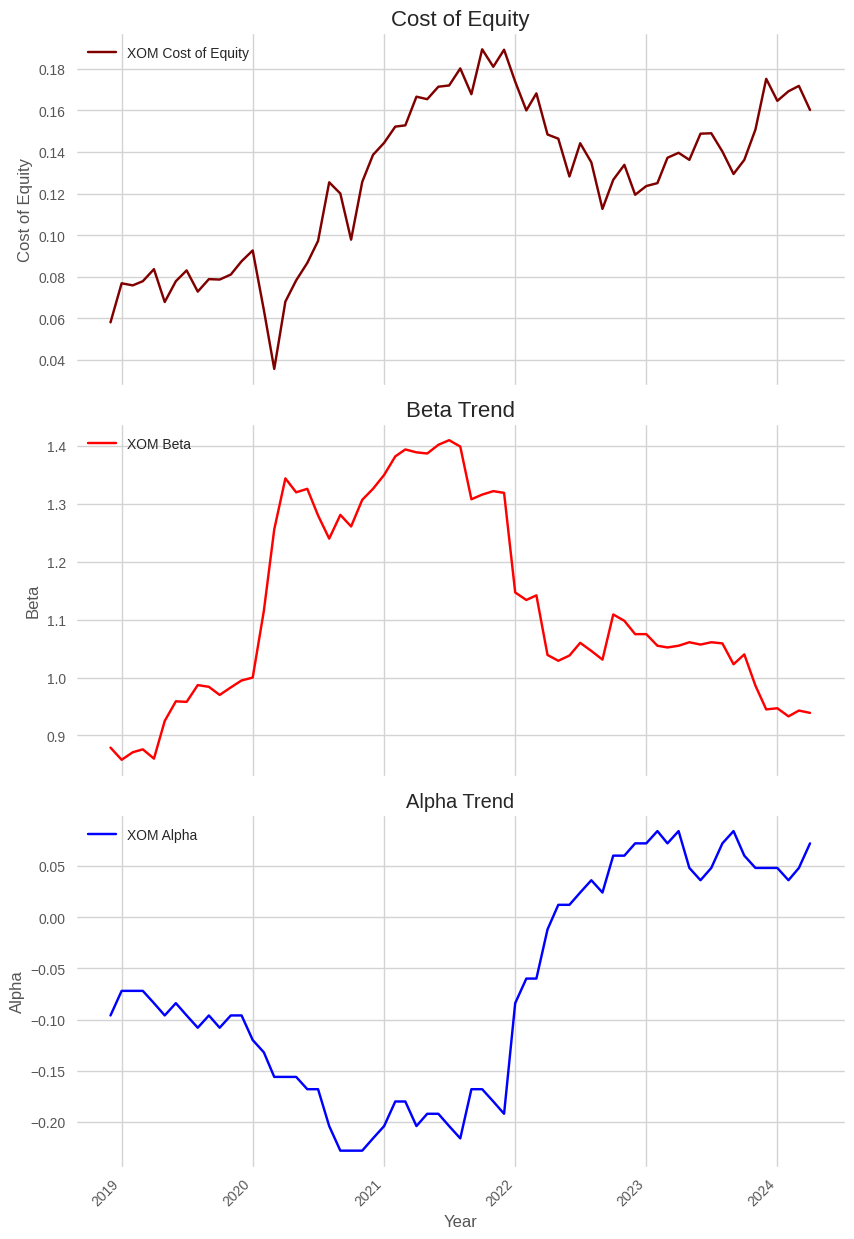

In [663]:
# Chart of cost of equity for each year for stock graphically

fig, axes = plt.subplots(nrows = 3, ncols = 1)
fig.set_size_inches(10, 12.5)

Moving = 60

axes[0].plot(COE["Date"], COE["Cost of Equity"].rolling(Moving).mean()*12, color = "maroon")
axes[0].set(title = "Cost of Equity", xlabel = "Year", ylabel = "Cost of Equity")
axes[0].title.set_size(16)
plt.grid(color = "lightgray")
axes[1].plot(COE["Date"][Moving-1:], COE["Beta"][Moving-1:], color = "red")
axes[1].set(title = "Beta Trend", xlabel = "Year", ylabel = "Beta")
axes[2].plot(COE["Date"][Moving-1:], COE["Alpha"][Moving-1:]*12, color = "blue")
axes[2].set(title = "Alpha Trend", xlabel = "Year", ylabel = "Alpha")

fig.autofmt_xdate(rotation=45) #format x-axis as date, rotate 45 degrees
axes[1].title.set_size(16)

#axes[0].set_ylim([-COE["Cost of Equity"].abs().max()*1.05*12,COE["Cost of Equity"].abs().max()*1.05*12])
#axes[1].set_ylim([COE["Beta"].min()-0.1,COE["Beta"].max()*1.05])
#axes[2].set_ylim([COE["Alpha"].min()-0.01*12,COE["Alpha"].max()*1.05*12])

axes[0].set_facecolor('white') #make background behind grid white
axes[1].set_facecolor('white')
axes[2].set_facecolor('white')

axes[0].legend([Trade_Name +" Cost of Equity"] ,loc = 2) #move legend to right
axes[1].legend([Trade_Name +" Beta"] ,loc = 2)
axes[2].legend([Trade_Name +" Alpha"] ,loc = 2)

fig.tight_layout() #use tight layout
fig.subplots_adjust(right = .85) #adjust subplots to make legend fit, adjusted this a bit from smaller figure example!
axes[0].grid(color = "lightgray")
axes[1].grid(color = "lightgray")
axes[2].grid(color = "lightgray")

plt.show()